# Ranking Education, Police and Sanitation by district of operation

The metrics we are going to use:
- Median and mean complaint resolution time.
- Number of complaints normalized by population. Note that there is no data about the population of the districts of operation, which are not related to NTAs, so we approximate it by a weighted sum of the population of the NTAs overlapping with the district.

In [176]:
import pandas as pd
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import json
import numpy as np
%matplotlib inline

In [ ]:
df_311 = pd.read_pickle("data/311_Service_Requests_from_2010_to_Present_small.pkl")
df_311.set_index("Unique Key")
relevant_columns = ["Created Date", "Closed Date", "Agency", "Complaint Type", "Latitude", "Longitude"]
df_311 = df_311[relevant_columns]
df_311.to_pickle("data/ranking_departments.pkl")

In [18]:
df_nta_population = pd.read_csv(
    "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")[["NTA Code", "Population"]].set_index("NTA Code")

In [55]:
# load GeoJSON file containing districts and create polygons
nta_geojson = "data/Neighborhood Tabulation Areas.geojson"
nta_id_field = "ntacode"
doe_geojson = "data/School Districts.geojson"
doe_id_field = "school_dist"
nypd_geojson = "data/Police Precincts.geojson"
nypd_id_field = "precinct"
fdny_geojson = "data/Fire Battalions.geojson"
fdny_id_field = "fire_bn"
dsny_geojson = "data/DSNY Districts.geojson"
dsny_id_field = "districtcode"
def get_polygons(geojson_path, id_field):
    with open(geojson_path) as f:
        js = json.load(f)
        return [(feature["properties"][id_field], shape(feature["geometry"])) for feature in js["features"]]

def get_district(row, polygons):
    """Retrieves the district of a given location in NYC.
    Args:
        row: 311 request with associated metadata (e.g. location)
    Returns:
        String: code of the district the location is part of, or NaN if the location is not within a district
    """
    longitude = row["Longitude"]
    latitude = row["Latitude"]
    point = Point(longitude, latitude)
    for polygon in polygons:
        if polygon[1].contains(point):
            district_code = polygon[0]
            return district_code
    return np.nan

In [ ]:
# split into agencies and use only those with present latitude and longitude
df_311 = df_311[df_311["Latitude"].notnull() & df_311["Longitude"].notnull()]
df_nypd = df_311[df_311["Agency"] == "NYPD"].drop(columns="Agency")
df_dsny = df_311[df_311["Agency"] == "DSNY"].drop(columns="Agency")
df_fdny = df_311[df_311["Agency"] == "FDNY"].drop(columns="Agency")
df_doe = df_311[df_311["Agency"] == "DOE"].drop(columns="Agency")

In [86]:
agencies = [(df_doe, doe_geojson, doe_id_field, []),
           (df_nypd, nypd_geojson, nypd_id_field, []),
           (df_dsny, dsny_geojson, dsny_id_field, []),
           (df_fdny, fdny_geojson, fdny_id_field, [])]

In [87]:
for agency in agencies:
    polygons = get_polygons(agency[1], agency[2])
    agency[0]["District"] = agency[0].apply(lambda x: get_district(x, polygons), axis=1)

In [88]:
nta_pop_df = pd.read_csv("data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv")

In [89]:
# the census is done every 10 years, so we have to depend on the 2010 data
nta_pop_df = nta_pop_df[nta_pop_df["Year"] == 2010][["NTA Code", "Population"]].set_index("NTA Code")

In [113]:
# Get estimated population of each district. We drop the three districts that have ill defined boundaries.
nta_polygons = get_polygons(nta_geojson, nta_id_field)
for agency in agencies:
    polygons = get_polygons(agency[1], agency[2])
    agency[3].clear()
    for polygon in polygons:
        district_population = 0
        district_failed = False
        for nta_polygon in nta_polygons:
            try:
                district_population += (nta_polygon[1].intersection(polygon[1]).area / nta_polygon[1].area) * \
                    nta_pop_df[nta_pop_df.index == nta_polygon[0]].values[0][0]
            except:
                print(f"failed for nta: {nta_polygon[0]} with district {polygon[0]}")
                district_failed = True
                break
        if district_failed:
            continue
        agency[3].append((polygon[0], district_population))

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -73.92136576611702 40.665492005998196 at -73.92136576611702 40.665492005998196


failed for nta: BK88 with district 17


TopologyException: Input geom 1 is invalid: Too few points in geometry component at or near point -73.905913525222076 40.587544309958552 at -73.905913525222076 40.587544309958552


failed for nta: QN10 with district 61


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -73.753770363982468 40.765304631984094 at -73.753770363982468 40.765304631984094


failed for nta: QN51 with district 53


In [157]:
agencies_df = [agency[0] for agency in agencies]
for i, agency in enumerate(agencies):
    time_diff = agencies_df[i]["Closed Date"] - agencies_df[i]["Created Date"]
    agencies_df[i]["Resolution Time (days)"] = time_diff.apply(lambda x: x.total_seconds() / (24 * 3600))

In [162]:
for agency in agencies_df:
    agency.rename(columns={"Resolution Time": "Resolution Time (days)"}, inplace=True)

In [171]:
for agency in agencies_df:
    print(len(agency))

18981
5097994
1832606
58


In [ ]:
# We realize that we have too few complaints from Fire Departments with specified location so we drop it.
# There are also not many such complaints to the department of education (~19k), but we decide to use this data.

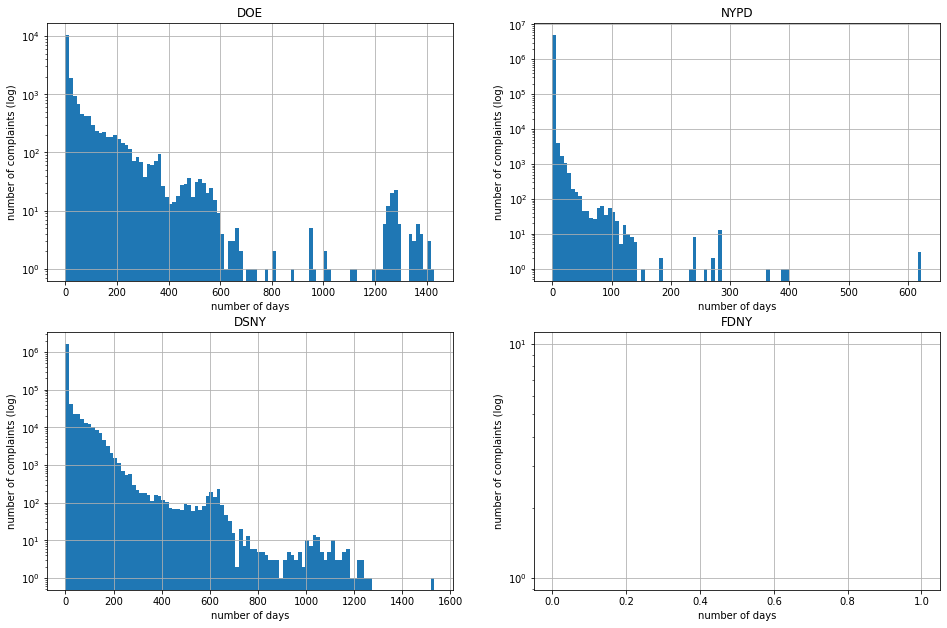

In [203]:
agency_names = ["DOE", "NYPD", "DSNY", "FDNY"]
f, axes = plt.subplots(2, 2, figsize=(16,9))
k = 0
plt.subplots_adjust(bottom=0.05)
for i in range(2):
    for j in range(2):
        axes[i, j].set_yscale("log")
        agencies_df[k]["Resolution Time (days)"].hist(ax=axes[i, j], bins=100)
        axes[i, j].set_title(agency_names[k])
        axes[i, j].set_ylabel("number of complaints (log)")
        axes[i, j].set_xlabel("number of days")
        k += 1

It appears that there are outliers in case of NYPD and DSNY. Histogram of the Department of Education shows unexpected spike around 1200 - 1400 days. We decide to keep those entries as they are most likely valid.

In [222]:
print("Most common call categories\n")
for i, agency in enumerate(agencies_df[:3]):
    print(agency_names[i])
    print(agency.groupby("Complaint Type").agg("size").sort_values(ascending=False).head(10))
    print()

Most common complaints

DOE
Complaint Type
School Maintenance               17259
Safety                             563
Discipline and Suspension          396
Teaching/Learning/Instruction      383
Registration and Transfers         155
Health                             155
Parent Leadership                   54
No Child Left Behind                16
Elevator                             0
Electronics Waste Appointment        0
dtype: int64

NYPD
Complaint Type
Noise - Residential            1762451
Blocked Driveway                891486
Illegal Parking                 871447
Noise - Street/Sidewalk         459908
Noise - Commercial              341325
Noise - Vehicle                 209198
Derelict Vehicle                206187
Non-Emergency Police Matter      66316
Animal Abuse                     51999
Vending                          41218
dtype: int64

DSNY
Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condit

We realize that even though the calls are supposedly complaints, they cannot always be classified as such. This is the case for many of the DSNY calls as it appears to be receiving regular requests for garbage collection through 311. 

In [227]:
agencies_df[2].groupby("Complaint Type").agg("size").sort_values(ascending=False).head(30)

Complaint Type
Dirty Conditions                       334757
Request Large Bulky Item Collection    325106
Sanitation Condition                   288091
Missed Collection (All Materials)      250855
Derelict Vehicles                      197538
Graffiti                               153017
Snow                                    75624
Other Enforcement                       57148
Electronics Waste Appointment           32624
Electronics Waste                       26473
Litter Basket / Request                 24845
Vacant Lot                              17176
Derelict Bicycle                        12770
Overflowing Litter Baskets              10715
Recycling Enforcement                    8408
Sweeping/Missed                          5649
Sweeping/Missed-Inadequate               5490
Request Xmas Tree Collection             1936
Sweeping/Inadequate                      1782
Collection Truck Noise                   1498
Adopt-A-Basket                            555
Missed Collection  

We decide to drop the calls categorized as:
- Request Large Bulky Item Collection
- Electronics Waste Appointment
- Electronics Waste
- Litter Basket / Request
- Request Xmas Tree Collection
- Adopt-A-Basket

In [245]:
agencies_df[2] = agencies_df[2][~agencies_df[2]["Complaint Type"].isin([
    "Adopt-A-Basket", "Request Xmas Tree Collection", "Litter Basket / Request", "Electronics Waste",
    "Electronics Waste Appointment", "Request Large Bulky Item Collection"
])]

In [246]:
agencies_df = agencies_df[:3]

In [259]:
for i, agency in enumerate(agencies_df):
    print(f"{agency_names[i]} entries: {len(agency)}")
    print("NaNs:")
    print(agency.isna().sum())
    print()

DOE entries: 18981
NaNs:
Created Date                0
Closed Date               401
Complaint Type              0
Latitude                    0
Longitude                   0
District                    0
District Population       548
Resolution Time (days)    401
dtype: int64

NYPD entries: 5097994
NaNs:
Created Date                  0
Closed Date                5126
Complaint Type                0
Latitude                      0
Longitude                     0
District                    483
District Population       87438
Resolution Time (days)     5126
dtype: int64

DSNY entries: 1421067
NaNs:
Created Date                  0
Closed Date               14870
Complaint Type                0
Latitude                      0
Longitude                     0
District                   2139
District Population        2139
Resolution Time (days)    14870
dtype: int64



We decide to drop the NaNs as they are a small minority of the calls.

In [ ]:
for agency in agencies_df:
    agency.dropna(inplace=True)

In [318]:
grouped_agencies = []
for i, agency in enumerate(agencies_df):
    grouped_agencies.append(agency.groupby("District")["Resolution Time (days)"].agg(["mean", "median", "count"])
                            .rename(columns={"median": "Median resolution time (days)",
                                             "mean": "Mean resolution time (days)",
                                             "count": "Number of complaints"}))
    district_population = pd.DataFrame(agencies[i][3]).set_index(0)
    grouped_agencies[i] = grouped_agencies[i].join(district_population).rename(columns={1: "District population"})
    grouped_agencies[i]["Complaints per 1k capita"] = \
        1000 * grouped_agencies[i]["Number of complaints"] / grouped_agencies[i]["District population"]
    grouped_agencies[i]["Mean resolution time rank"] = grouped_agencies[i]["Mean resolution time (days)"].rank()
    grouped_agencies[i]["Median resolution time rank"] = grouped_agencies[i]["Median resolution time (days)"].rank(method="first")
    grouped_agencies[i]["Number of complaints rank"] = grouped_agencies[i]["Number of complaints"].rank(method="first")
    grouped_agencies[i]["Complaints per 1k capita rank"] = grouped_agencies[i]["Complaints per 1k capita"].rank(method="first")
    grouped_agencies[i].sort_values("Complaints per 1k capita", inplace=True)
    # drop districts with very small number of inhabitants. As previously noted those are often parks
    grouped_agencies[i] = grouped_agencies[i][grouped_agencies[i]["District population"] > 10000]

In [323]:
print(agency_names[0])
grouped_agencies[0].to_pickle("data/doe_ranking.pkl")
grouped_agencies[0]

DOE


,Mean resolution time (days),Median resolution time (days),Number of complaints,District population,Complaints per 1k capita,Mean resolution time rank,Median resolution time rank,Number of complaints rank,Complaints per 1k capita rank
25,48.245648,6.781169,317,301040.353512,1.053015,8.0,4.0,7.0,1.0
24,58.812659,16.800856,523,429536.260405,1.217592,20.0,30.0,18.0,2.0
18,72.954060,13.018310,277,180272.543347,1.536562,28.0,23.0,4.0,3.0
29,44.955152,6.673495,419,271427.830649,1.543688,3.0,3.0,11.0,4.0
14,48.536408,6.940955,364,204633.579255,1.778789,10.0,7.0,10.0,5.0
30,45.441062,5.675822,673,375969.527534,1.790039,5.0,1.0,23.0,6.0
22,54.356691,7.586395,656,356960.305227,1.837739,14.0,9.0,22.0,7.0
26,81.840543,14.120382,361,195326.144995,1.848191,31.0,27.0,9.0,8.0
27,107.081237,22.108137,691,366182.058151,1.887039,32.0,32.0,24.0,9.0
2,66.360860,14.204850,1377,716804.582748,1.921026,25.0,28.0,30.0,10.0


In [324]:
print(agency_names[1])
grouped_agencies[1].to_pickle("data/nypd_ranking.pkl")
grouped_agencies[1]

NYPD


,Mean resolution time (days),Median resolution time (days),Number of complaints,District population,Complaints per 1k capita,Mean resolution time rank,Median resolution time rank,Number of complaints rank,Complaints per 1k capita rank
District,,,,,,,,,
123,0.123429,0.080139,32097,104936.888290,305.869561,21.0,27.0,10.0,1.0
19,0.138272,0.088264,61105,195531.903028,312.506548,29.0,33.0,39.0,2.0
111,0.120132,0.082882,37379,116994.866595,319.492650,18.0,29.0,15.0,3.0
122,0.169652,0.115365,46766,144021.768957,324.714801,50.0,53.0,25.0,4.0
20,0.114470,0.064792,34964,107120.977967,326.397319,15.0,6.0,12.0,5.0
...,...,...,...,...,...,...,...,...,...
14,0.107538,0.064213,30554,30683.365562,995.783854,9.0,5.0,8.0,71.0
83,0.129479,0.085046,102936,102344.920606,1005.775366,26.0,30.0,65.0,72.0
28,0.114196,0.071053,49879,45898.867032,1086.715277,14.0,13.0,29.0,73.0


In [325]:
print(agency_names[2])
grouped_agencies[2].to_pickle("data/dsny_ranking.pkl")
grouped_agencies[2]

DSNY


,Mean resolution time (days),Median resolution time (days),Number of complaints,District population,Complaints per 1k capita,Mean resolution time rank,Median resolution time rank,Number of complaints rank,Complaints per 1k capita rank
District,,,,,,,,,
107,10.459020,1.213889,13414,200571.338371,66.878947,22.0,28.0,15.0,1.0
108,13.264727,1.161111,15220,219020.148785,69.491323,33.0,21.0,20.0,2.0
109,20.195355,1.843056,8007,113264.247086,70.693093,50.0,47.0,2.0,3.0
205,23.054209,1.929861,8829,120788.208561,73.094883,56.0,51.0,4.0,4.0
106,10.195113,1.626736,9564,129661.966748,73.761028,19.0,38.0,6.0,5.0
204,18.284708,1.638889,10739,140259.848824,76.565033,48.0,40.0,10.0,6.0
112,24.169903,2.077083,14769,189956.632561,77.749325,57.0,57.0,19.0,7.0
111,17.429179,1.379861,9711,120940.377683,80.295764,47.0,30.0,7.0,8.0
207,16.920172,1.588194,11658,144203.079104,80.844321,46.0,36.0,13.0,9.0
